In [44]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json

from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

from qibo import models
from qaoa_utils import exprectum_hamiltonian, create_gibbs_state, create_gausgibbs_state, expected_value, sample_state, build_maxcut_hamiltonian, build_mixer_hamiltonian

# **Energy Landscape**

In [24]:
n = 7
p = 0.5

G = nx.erdos_renyi_graph(n, p)

dict_values = exprectum_hamiltonian(G)

gibbs_state = create_gibbs_state(dict_values, t = 3)
expected_value_gibbs_state = expected_value(state = gibbs_state, dict_values = dict_values)

pseudo_gibbs_state = create_gausgibbs_state(solutions_dict = dict_values, 
                                            delta_energy = 0.6, 
                                            mu_energy = expected_value_gibbs_state)

expected_value_psgibbs_state = expected_value(state=pseudo_gibbs_state, dict_values=dict_values)

dict_pb_gibbs = sample_state(gibbs_state)

pb_gibbs = list(dict_pb_gibbs.values())

entropy_gibbs = -sum(
pb_gibbs[i] * np.log2(pb_gibbs[i])
for i in range(len(pb_gibbs))
if pb_gibbs[i] != 0 )

dict_pb_psgibbs = sample_state(pseudo_gibbs_state)

pb_psgibbs = list(dict_pb_psgibbs.values())

entropy_psgibbs = -sum(
    pb_psgibbs[i] * np.log2(pb_psgibbs[i])
    for i in range(len(pb_psgibbs))
    if pb_psgibbs[i] != 0
        )

hamiltonian = build_maxcut_hamiltonian(graph = G)

mixer_hamiltonian = build_mixer_hamiltonian(graph = G)

print('Energy Gibbs:', expected_value_gibbs_state, 'Entropy Gibbs:', entropy_gibbs)
print('Energy PsGibbs:', expected_value_psgibbs_state, 'Entropy PsGibbs:', entropy_psgibbs)


alpha = np.linspace(-2 * np.pi, 2 * np.pi, 60)
beta = np.linspace(-2 * np.pi, 2 * np.pi, 60)

energy_psgibbs_dict_mc = {}

for a in alpha:
    for b in beta:
        
        final_parameters = np.array([a, b])
        
        qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)
        
        qaoa.set_parameters(final_parameters)
        
        quantum_state = qaoa.execute(initial_state = pseudo_gibbs_state)
        
        value = expected_value(state = quantum_state, dict_values = dict_values)
        
        energy_psgibbs_dict_mc[(a, b)] = value
        
energy_gibbs_dict_mc = {}

for a in alpha:
    for b in beta:
        
        final_parameters = np.array([a, b])
        
        qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)
        
        qaoa.set_parameters(final_parameters)
        
        quantum_state = qaoa.execute(initial_state = gibbs_state)
        
        value = expected_value(state = quantum_state, dict_values = dict_values)
        
        energy_gibbs_dict_mc[(a, b)] = value

Energy Gibbs: -6.246604043415004 Entropy Gibbs: 6.106607099183624
Energy PsGibbs: -6.019066951540577 Entropy PsGibbs: 4.679977884421647


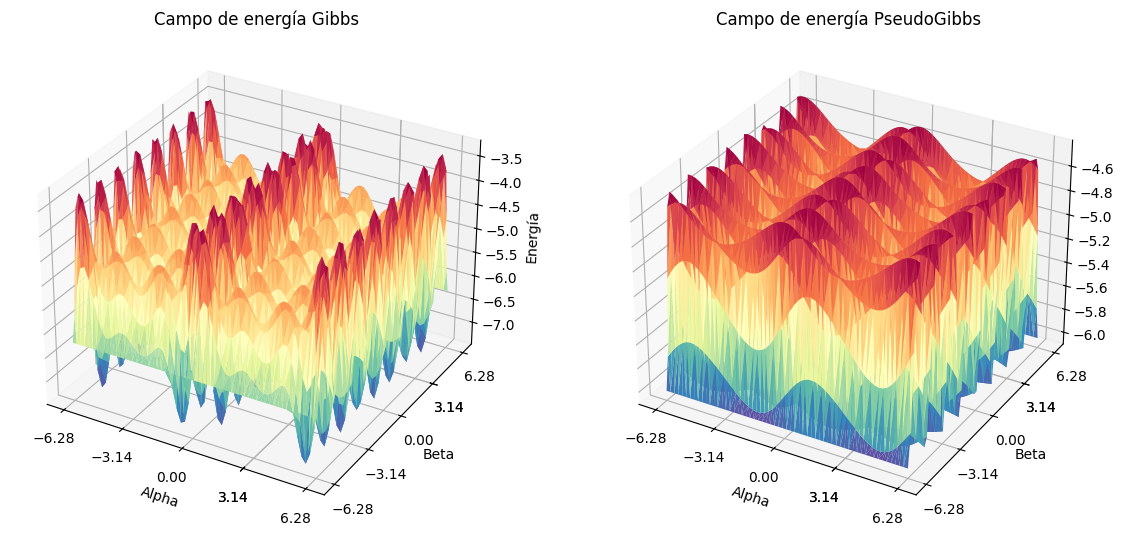

In [25]:
x_gibbs, y_gibbs = zip(*energy_gibbs_dict_mc.keys())
z_gibbs = list(energy_gibbs_dict_mc.values())

x_psgibbs, y_psgibbs = zip(*energy_psgibbs_dict_mc.keys())
z_psgibbs = list(energy_psgibbs_dict_mc.values())

cmap = sns.color_palette("Spectral", as_cmap=True)
cmap = cmap.reversed()

fig = plt.figure(figsize=(14, 7))

ax1 = fig.add_subplot(121, projection="3d")
ax1.plot_trisurf(x_gibbs, y_gibbs, z_gibbs, cmap=cmap)
ax1.set_xlabel("Alpha")
ax1.set_ylabel("Beta")
ax1.set_zlabel("Energía")
ax1.set_xticks([-2 * np.pi, -np.pi, 0, np.pi, np.pi, 2 * np.pi])
ax1.set_yticks([-2 * np.pi, -np.pi, 0, np.pi, np.pi, 2 * np.pi])
ax1.set_title("Campo de energía Gibbs")


ax2 = fig.add_subplot(122, projection="3d")
ax2.plot_trisurf(x_psgibbs, y_psgibbs, z_psgibbs, cmap=cmap)
ax2.set_xlabel("Alpha")
ax2.set_ylabel("Beta")
ax1.set_zlabel("Energía")
ax2.set_xticks([-2 * np.pi, -np.pi, 0, np.pi, np.pi, 2 * np.pi])
ax2.set_yticks([-2 * np.pi, -np.pi, 0, np.pi, np.pi, 2 * np.pi])
ax2.set_title("Campo de energía PseudoGibbs")


plt.show()

# **Tests Gibbs vs One State**

In [26]:
list_list_energy_qaoa_difference_3_layers = []

for j in range(6, 13):
    
    list_energy_qaoa_difference_3_layers = []
    
    for i in range(30):
        
        path_data_qaoa = f'logger_data_qaoa_performance_gibbs_states_borders_one_state/logger_data_max_cut_qaoa_common_instances_n_{j}_borders/cmaes_qaoa_max_cut_n_{j}_t_4_layers_3_case_{i}.json'
        
        with open(path_data_qaoa) as f:
            
            data = json.load(f)
            
        energy_qaoa_gibbs_state = data['energy_qaoa_gibbs_state'] 
        energy_qaoa_one_state = data['energy_qaoa_one_state']
        
        energy_value_exact = data['energy_value_exact']
        
        relative_energy_qaoa_gibbs_state = (abs(energy_value_exact) - abs(energy_qaoa_gibbs_state))/abs(energy_value_exact)
        relative_energy_qaoa_one_state = (abs(energy_value_exact) - abs(energy_qaoa_one_state))/abs(energy_value_exact)
                
        difference = relative_energy_qaoa_one_state - relative_energy_qaoa_gibbs_state
        
        list_energy_qaoa_difference_3_layers.append(difference*100)
    
    list_list_energy_qaoa_difference_3_layers.append(list_energy_qaoa_difference_3_layers)

In [27]:
list_list_energy_qaoa_difference_5_layers = []

for j in range(6, 13):
    
    list_energy_qaoa_difference_5_layers = []
    
    for i in range(30):
        
        path_data_qaoa = f"logger_data_qaoa_performance_gibbs_states_borders_one_state/logger_data_max_cut_qaoa_common_instances_n_{j}_borders/cmaes_qaoa_max_cut_n_{j}_t_4_layers_5_case_{i}.json"
        
        with open(path_data_qaoa) as f:
            
            data = json.load(f)
            
        energy_qaoa_gibbs_state = data['energy_qaoa_gibbs_state'] 
        energy_qaoa_one_state = data['energy_qaoa_one_state']
        
        energy_value_exact = data['energy_value_exact']
        
        relative_energy_qaoa_gibbs_state = (abs(energy_value_exact) - abs(energy_qaoa_gibbs_state))/abs(energy_value_exact)
        relative_energy_qaoa_one_state = (abs(energy_value_exact) - abs(energy_qaoa_one_state))/abs(energy_value_exact)
                
        difference =  relative_energy_qaoa_one_state -relative_energy_qaoa_gibbs_state 
        
        list_energy_qaoa_difference_5_layers.append(difference*100)
    
    list_list_energy_qaoa_difference_5_layers.append(list_energy_qaoa_difference_5_layers)

In [28]:
list_list_energy_qaoa_difference_7_layers = []

for j in range(6, 13):
    
    list_energy_qaoa_difference_7_layers = []
    
    for i in range(30):
        
        path_data_qaoa = f"logger_data_qaoa_performance_gibbs_states_borders_one_state/logger_data_max_cut_qaoa_common_instances_n_{j}_borders/cmaes_qaoa_max_cut_n_{j}_t_4_layers_7_case_{i}.json"
        
        with open(path_data_qaoa) as f:
            
            data = json.load(f)
            
        energy_qaoa_gibbs_state = data['energy_qaoa_gibbs_state'] 
        energy_qaoa_one_state = data['energy_qaoa_one_state']
        
        energy_value_exact = data['energy_value_exact']
        
        relative_energy_qaoa_gibbs_state = (abs(energy_value_exact) - abs(energy_qaoa_gibbs_state))/abs(energy_value_exact)
        relative_energy_qaoa_one_state = (abs(energy_value_exact) - abs(energy_qaoa_one_state))/abs(energy_value_exact)
                
        difference = relative_energy_qaoa_one_state - relative_energy_qaoa_gibbs_state 
        
        list_energy_qaoa_difference_7_layers.append(difference*100)
    
    list_list_energy_qaoa_difference_7_layers.append(list_energy_qaoa_difference_7_layers)

In [29]:
def create_dataframe(lst, layers_value):

    expanded_data = []
    problem_sizes = []
    layers = []  

    for idx, sublist in enumerate(lst):
        problem_size = idx + 6

        for value in sublist:

            expanded_data.append(value)

            problem_sizes.append(problem_size)
           
            layers.append(layers_value)

    # Crear un DataFrame a partir de los datos expandidos
    df = pd.DataFrame({
        'value': expanded_data,
        'size': problem_sizes,
        'layers': layers  # Añadir la columna 'Layers'
    })
    return df


df_3_layers = create_dataframe(lst = list_list_energy_qaoa_difference_3_layers, layers_value = 3)
df_5_layers = create_dataframe(lst = list_list_energy_qaoa_difference_5_layers, layers_value = 5)
df_7_layers = create_dataframe(lst = list_list_energy_qaoa_difference_7_layers, layers_value = 7)

result = pd.concat([df_3_layers, df_5_layers, df_7_layers], ignore_index=True)

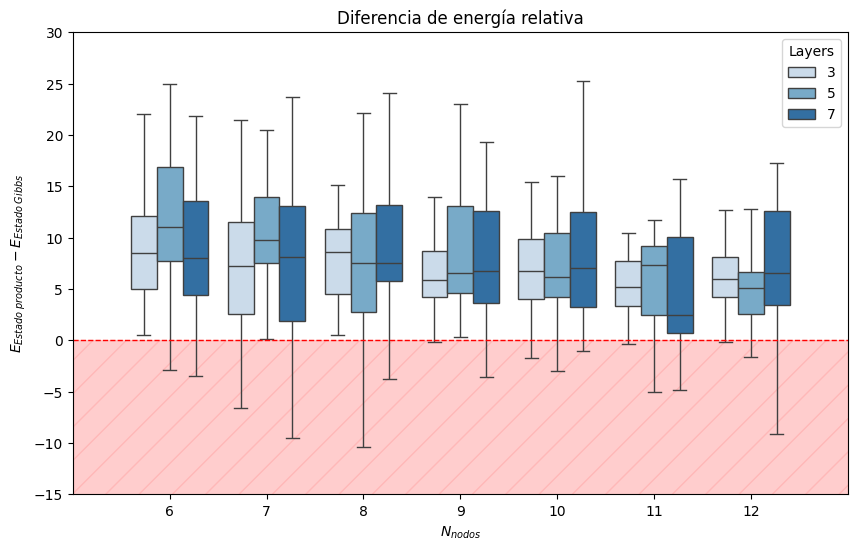

In [30]:
plt.figure(figsize=(10, 6))  

n_layers = result['layers'].nunique()

layers_palette = sns.color_palette('Blues', n_colors=n_layers)

sns.boxplot(x='size', y='value', hue='layers', data=result, palette=layers_palette, showfliers=False)

plt.ylim(-15, 30)
plt.xlim(-1, 7)
plt.axhspan(ymin=-25, ymax=0, facecolor='red', alpha=0.1)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

plt.fill_betweenx([-25, 0], -1, 7, facecolor='red', alpha=0.1, hatch='/', edgecolor='red')


plt.title('Diferencia de energía relativa')
plt.xlabel(r'$N_{nodos}$')
plt.ylabel(r'$ E_{Estado \; producto} - E_{Estado \; Gibbs}$')
plt.legend(title='Layers')

plt.show()

# **Tests Gibbs vs Hadamard State**

**Hadamard vs Gibbs with T fixed**

In [31]:
list_list_energy_qaoa_difference_3_layers = []

for j in range(5, 13):
    
    list_energy_qaoa_difference_3_layers = []
    
    for i in range(30):
        
        path_data_qaoa = f"logger_data_qaoa_performance_gibbs_states_borders_hadamard_state/logger_data_max_cut_qaoa_common_instances_n_{j}_borders/cmaes_qaoa_max_cut_n_{j}_t_1_layers_3_case_{i}.json"
        
        with open(path_data_qaoa) as f:
            
            data = json.load(f)
            
        energy_qaoa_gibbs_state = data['energy_qaoa_gibbs_state'] 
        energy_qaoa_one_state = data['energy_qaoa_hadamard_state']
        
        energy_value_exact = data['energy_value_exact']
        
        relative_energy_qaoa_gibbs_state = (abs(energy_value_exact) - abs(energy_qaoa_gibbs_state))/abs(energy_value_exact)
        relative_energy_qaoa_one_state = (abs(energy_value_exact) - abs(energy_qaoa_one_state))/abs(energy_value_exact)
                
        difference = relative_energy_qaoa_one_state - relative_energy_qaoa_gibbs_state
        
        list_energy_qaoa_difference_3_layers.append(difference*100)
    
    list_list_energy_qaoa_difference_3_layers.append(list_energy_qaoa_difference_3_layers)

In [32]:
list_list_energy_qaoa_difference_5_layers = []

for j in range(5, 13):
    
    list_energy_qaoa_difference_5_layers = []
    
    for i in range(30):
        
        path_data_qaoa = f"logger_data_qaoa_performance_gibbs_states_borders_hadamard_state/logger_data_max_cut_qaoa_common_instances_n_{j}_borders/cmaes_qaoa_max_cut_n_{j}_t_1_layers_5_case_{i}.json"
        
        with open(path_data_qaoa) as f:
            
            data = json.load(f)
            
        energy_qaoa_gibbs_state = data['energy_qaoa_gibbs_state'] 
        energy_qaoa_one_state = data['energy_qaoa_hadamard_state']
        
        energy_value_exact = data['energy_value_exact']
        
        relative_energy_qaoa_gibbs_state = (abs(energy_value_exact) - abs(energy_qaoa_gibbs_state))/abs(energy_value_exact)
        relative_energy_qaoa_one_state = (abs(energy_value_exact) - abs(energy_qaoa_one_state))/abs(energy_value_exact)
                
        difference = relative_energy_qaoa_one_state - relative_energy_qaoa_gibbs_state
        
        list_energy_qaoa_difference_5_layers.append(difference*100)
    
    list_list_energy_qaoa_difference_5_layers.append(list_energy_qaoa_difference_5_layers)

In [33]:
def create_dataframe(lst, layers_value):

    expanded_data = []
    problem_sizes = []
    layers = []  

    for idx, sublist in enumerate(lst):
        
        problem_size = idx + 5

        for value in sublist:

            expanded_data.append(value)

            problem_sizes.append(problem_size)
           
            layers.append(layers_value)

    # Crear un DataFrame a partir de los datos expandidos
    df = pd.DataFrame({
        'value': expanded_data,
        'size': problem_sizes,
        'layers': layers  # Añadir la columna 'Layers'
    })
    return df


df_3_layers = create_dataframe(lst = list_list_energy_qaoa_difference_3_layers, layers_value = 3)
df_5_layers = create_dataframe(lst = list_list_energy_qaoa_difference_5_layers, layers_value = 5)

result = pd.concat([df_3_layers, df_5_layers], ignore_index=True)

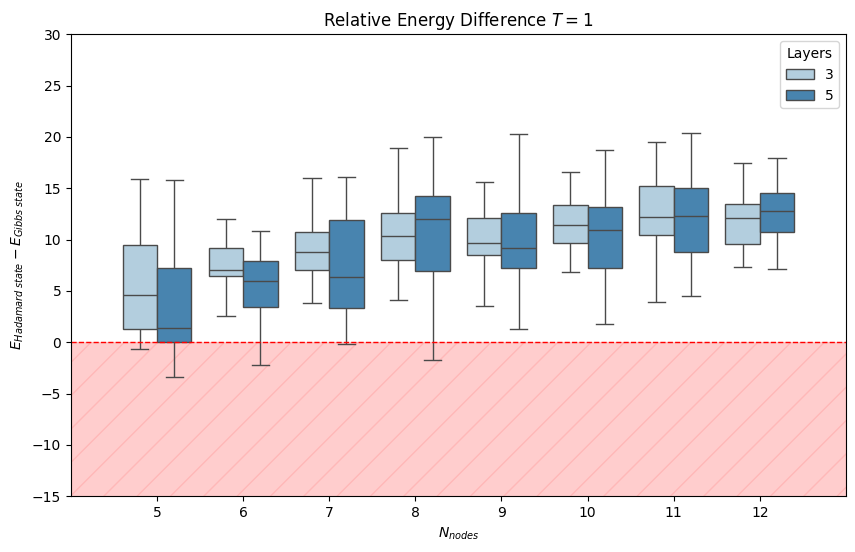

In [34]:
plt.figure(figsize=(10, 6))  

n_layers = result['layers'].nunique()

layers_palette = sns.color_palette('Blues', n_colors=n_layers)

sns.boxplot(x='size', y='value', hue='layers', data=result, palette=layers_palette, showfliers=False)

plt.ylim(-15, 30)
plt.xlim(-1, 8)
plt.axhspan(ymin=-25, ymax=0, facecolor='red', alpha=0.1)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

plt.fill_betweenx([-25, 0], -1, 8, facecolor='red', alpha=0.1, hatch='/', edgecolor='red')


plt.title(r'Relative Energy Difference $T=1$')
plt.xlabel(r'$N_{nodes}$')
plt.ylabel(r'$ E_{Hadamard \; state} - E_{Gibbs \; state}$')
plt.legend(title='Layers')

plt.show()

**Hadamard vs Gibbs with N nodes fixed**

In [35]:
list_list_energy_qaoa_difference_3_layers_t = []
nodes = 16
layers = 3

for t in [0.5,1,2,3,4,5,6]:
    
    list_energy_qaoa_difference_3_layers_t = []
    
    for i in range(30):
        
        path_data_qaoa = f"logger_data_qaoa_performance_gibbs_states_borders_hadamard_state/logger_data_max_cut_qaoa_common_instances_n_{nodes}_borders/cmaes_qaoa_max_cut_n_{nodes}_t_{t}_layers_{layers}_case_{i}.json"
        
        with open(path_data_qaoa) as f:
            
            data = json.load(f)
            
        energy_qaoa_gibbs_state = data['energy_qaoa_gibbs_state'] 
        energy_qaoa_one_state = data['energy_qaoa_hadamard_state']
        
        energy_value_exact = data['energy_value_exact']
        
        relative_energy_qaoa_gibbs_state = (abs(energy_value_exact) - abs(energy_qaoa_gibbs_state))/abs(energy_value_exact)
        relative_energy_qaoa_one_state = (abs(energy_value_exact) - abs(energy_qaoa_one_state))/abs(energy_value_exact)
                
        difference = relative_energy_qaoa_one_state - relative_energy_qaoa_gibbs_state
        
        list_energy_qaoa_difference_3_layers_t.append(difference*100)
    
    list_list_energy_qaoa_difference_3_layers_t.append(list_energy_qaoa_difference_3_layers_t)

In [36]:
list_list_energy_qaoa_difference_5_layers_t = []
nodes = 16
layers = 5

for t in [0.5,1,2,3,4,5,6]:
    
    list_energy_qaoa_difference_5_layers_t = []
    
    for i in range(30):
        
        path_data_qaoa = f"logger_data_qaoa_performance_gibbs_states_borders_hadamard_state/logger_data_max_cut_qaoa_common_instances_n_{nodes}_borders/cmaes_qaoa_max_cut_n_{nodes}_t_{t}_layers_{layers}_case_{i}.json"
        
        with open(path_data_qaoa) as f:
            
            data = json.load(f)
            
        energy_qaoa_gibbs_state = data['energy_qaoa_gibbs_state'] 
        energy_qaoa_one_state = data['energy_qaoa_hadamard_state']
        
        energy_value_exact = data['energy_value_exact']
        
        relative_energy_qaoa_gibbs_state = (abs(energy_value_exact) - abs(energy_qaoa_gibbs_state))/abs(energy_value_exact)
        relative_energy_qaoa_one_state = (abs(energy_value_exact) - abs(energy_qaoa_one_state))/abs(energy_value_exact)
                
        difference = relative_energy_qaoa_one_state - relative_energy_qaoa_gibbs_state
        
        list_energy_qaoa_difference_5_layers_t.append(difference*100)
    
    list_list_energy_qaoa_difference_5_layers_t.append(list_energy_qaoa_difference_5_layers_t)

In [37]:
def create_dataframe(lst, layers_value):

    expanded_data = []
    problem_sizes = []
    layers = []  

    for idx, sublist in enumerate(lst):
        
        problem_size = idx + 0.5

        for value in sublist:

            expanded_data.append(value)

            problem_sizes.append(problem_size)
           
            layers.append(layers_value)

    # Crear un DataFrame a partir de los datos expandidos
    df = pd.DataFrame({
        'value': expanded_data,
        'size': problem_sizes,
        'layers': layers  # Añadir la columna 'Layers'
    })
    return df


df_3_layers = create_dataframe(lst = list_list_energy_qaoa_difference_3_layers_t, layers_value = 3)
df_5_layers = create_dataframe(lst = list_list_energy_qaoa_difference_5_layers_t, layers_value = 5)

result = pd.concat([df_3_layers, df_5_layers], ignore_index=True)

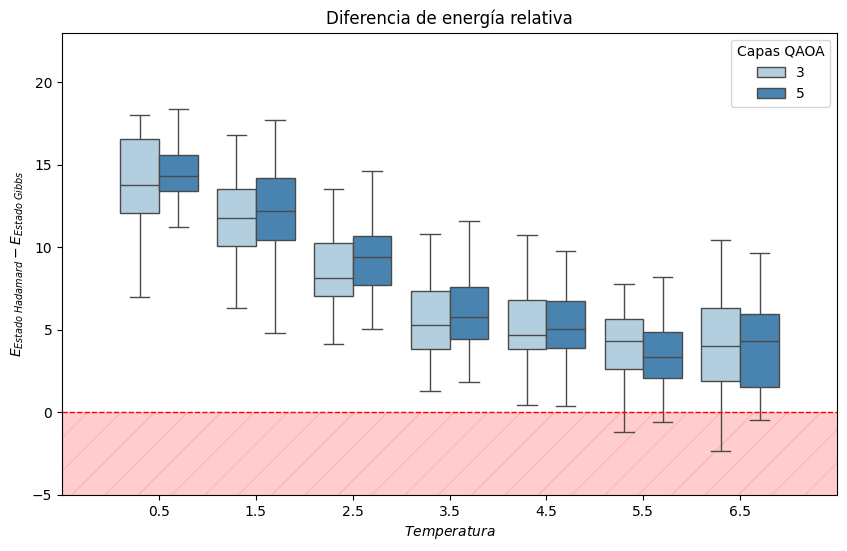

In [38]:
plt.figure(figsize=(10, 6))  

n_layers = result['layers'].nunique()

layers_palette = sns.color_palette('Blues', n_colors=n_layers)

sns.boxplot(x='size', y='value', hue='layers', data=result, palette=layers_palette, showfliers=False)

plt.ylim(-5, 23)
plt.xlim(-1, 7)
plt.axhspan(ymin=-25, ymax=0, facecolor='red', alpha=0.1)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

plt.fill_betweenx([-25, 0], -1, 8, facecolor='red', alpha=0.1, hatch='/', edgecolor='red')


plt.title(r'Diferencia de energía relativa')
plt.xlabel(r'$Temperatura$')
plt.ylabel(r'$ E_{Estado \; Hadamard} - E_{Estado \; Gibbs}$')
plt.legend(title='Capas QAOA')

plt.show()

# **Tests Gibbs vs Pseduo Gibbs**

In [45]:
list_list_entropy_gibbs_state = []
list_list_entropy_pseudo_gibbs_state = []
list_list_energy_qaoa_gibbs_state = []
list_list_energy_qaoa_pseudo_gibbs_state = []


for i in np.arange(0.3, 0.9 + 0.2, 0.2).round(2):

    list_entropy_gibbs_state = []
    list_entropy_pseudo_gibbs_state = []
    list_energy_qaoa_gibbs_state = []
    list_energy_qaoa_pseudo_gibbs_state = []
    
    for j in range(9):
        
        path_data_qaoa = f"logger_data_qaoa_performance_gibbs_states_border_pseudoGibbs_state/cmaes_qaoa_max_cut_n_9_case_{j}_t_4_layers_3_delta_gauss_{i}.json"
        
        with open(path_data_qaoa) as f:
            
            data = json.load(f)
        
        entropy_gibbs = data['entropy_gibbs_state']
        entropy_psgibbs = data['entropy_psgibbs_state']
        energy_qaoa_gibbs = data['energy_qaoa_gibbs_state']
        energy_qaoa_psgibbs = data['energy_qaoa_one_state']
        exact_energy = data['energy_value_exact']
        
        list_entropy_pseudo_gibbs_state.append(abs(entropy_psgibbs)/entropy_gibbs)
        list_entropy_gibbs_state.append(entropy_gibbs/entropy_gibbs)
        list_energy_qaoa_gibbs_state.append((abs(exact_energy)- abs(energy_qaoa_gibbs))/abs(exact_energy))
        list_energy_qaoa_pseudo_gibbs_state.append((abs(exact_energy) - abs(energy_qaoa_psgibbs))/abs(exact_energy))
        
    list_list_entropy_gibbs_state.append(list_entropy_gibbs_state)
    list_list_entropy_pseudo_gibbs_state.append(list_entropy_pseudo_gibbs_state)
    list_list_energy_qaoa_gibbs_state.append(list_energy_qaoa_gibbs_state)
    list_list_energy_qaoa_pseudo_gibbs_state.append(list_energy_qaoa_pseudo_gibbs_state)


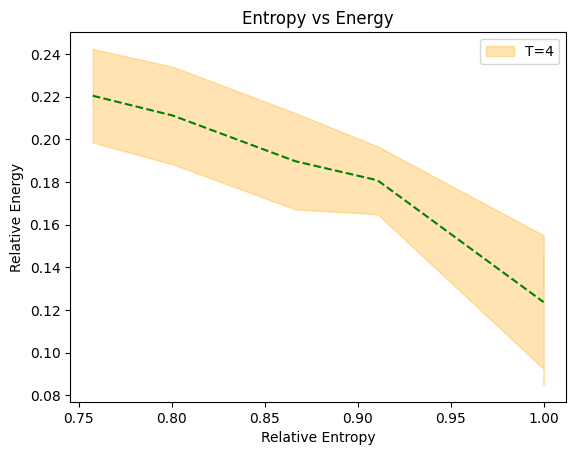

In [46]:
import numpy as np

x = list_list_entropy_pseudo_gibbs_state + list_list_entropy_gibbs_state
y = list_list_energy_qaoa_pseudo_gibbs_state + list_list_energy_qaoa_gibbs_state

x_means = [np.mean(data) for data in x]
y_means = [np.mean(data) for data in y]
x_errors = [np.std(data) for data in x]
y_errors = [np.std(data) for data in y]

# Graficar puntos de dispersión
#sns.scatterplot(x=x_means, y=y_means)

# Añadir sombreado de incertidumbre en el eje y
plt.fill_between(x_means, np.array(y_means) - np.array(y_errors), np.array(y_means) + np.array(y_errors), color='orange', alpha=0.3, label = 'T=4')

# Calcular nuevos puntos y errores para Gibbs State
new_x = np.mean(list_list_entropy_gibbs_state[-1])
new_y = np.mean(list_list_energy_qaoa_gibbs_state[-1])
new_y_err = np.std(list_list_energy_qaoa_gibbs_state[-1])


# Conectar los puntos con una línea
#plt.plot(x_means[:-3], y_means[:-3], color='orange')
plt.plot(x_means[:-3], y_means[:-3], color='green', linestyle='--')

# Configurar etiquetas y título
plt.xlabel('Relative Entropy')
plt.ylabel('Relative Energy')
plt.title('Entropy vs Energy')

# Mostrar el gráfico con leyenda
plt.grid(False)
plt.legend()  # Mostrar la leyenda con el nuevo punto
plt.show()

# **Heat Map**

In [41]:
ruta_json = f'logger_data_qaoa_performance_gibbs_states_heat_map/case_1_heat_map_n_8_layers_5.json'

df = pd.read_json(ruta_json)

In [42]:
df_nuevo = pd.DataFrame()

df_nuevo['energy']= pd.concat([df['energy_pseudo_gibbs_state'], 
                               df['energy_gibbs_state'], 
                               df['energy_one_state_final'],
                               df['energy_hadamard_state'],
                               df['energy_one_state'],
                               df['energy_random_state'],
                               ], 
                               axis=0, ignore_index=True)

df_nuevo['entropy']= pd.concat([df['entropy_pseudo_gibbs_state'], 
                                df['entropy_gibbs_state'],
                                df['entropy_one_state_final'],  
                                df['entropy_hadamard_state'],
                                df['entropy_one_state'],
                                df['entropy_random_state'],
                                ], 
                                axis=0, ignore_index=True)

df_nuevo['energy_QAOA']= pd.concat([df['energy_qaoa_pseudo_gibbs_state'], 
                                    df['energy_qaoa_gibbs_state'],
                                    df['energy_qaoa_one_state_final'], 
                                    df['energy_qaoa_hadamard_state'],
                                    df['energy_qaoa_one_state'],
                                    df['energy_qaoa_random_state'],
                                    ], 
                                    axis=0, ignore_index=True)

def find_closest_e_sol_g(row, df):
    closest_idx = (np.abs(df['energy_gibbs_state'] - row['energy'])).idxmin()
    return df.at[closest_idx, 'energy_qaoa_gibbs_state']

# Aplicar la función a cada fila de df1 y crear una nueva columna 'closest_e_sol_g'
df_nuevo['energy_ref'] = df_nuevo.apply(find_closest_e_sol_g, axis=1, df=df)

df_nuevo['relative_energy_final_gibbs'] = (abs(df_nuevo['energy_QAOA'].abs() - df_nuevo['energy_ref'].abs()))/df_nuevo['energy_ref'].abs()



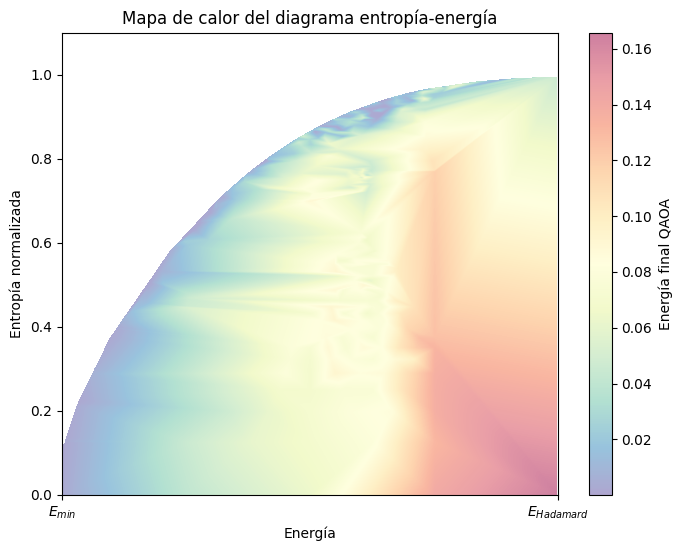

In [43]:
plt.figure(figsize=(8, 6))  


x_min, x_max = df_nuevo['energy'].min(), df_nuevo['energy'].max()
y_min, y_max = df_nuevo['entropy'].min(), df_nuevo['entropy'].max()

	
x_grid, y_grid = np.mgrid[x_min:x_max:5000j, y_min:y_max:5000j]

# Interpolar los valores de z sobre la cuadrícula usando griddata

points = np.array(df_nuevo[['energy', 'entropy']])
values = np.array(df_nuevo['relative_energy_final_gibbs'])
z_grid = griddata(points, values, (x_grid, y_grid), method='linear')

#cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap = sns.color_palette("Spectral", as_cmap=True)
cmap = cmap.reversed()

sigma = 3
z_grid_smooth = gaussian_filter(z_grid, sigma=sigma)

plt.imshow(z_grid_smooth.T, extent=(x_min,x_max, y_min, y_max), origin='lower', cmap=cmap, aspect='auto', alpha=0.5)
plt.colorbar(label='Energía final QAOA')
plt.ylim(0, 1.1)

plt.xticks([x_min, x_max], [r'$E_{min}$', r'$E_{Hadamard}$'])
plt.title('Mapa de calor del diagrama entropía-energía')
plt.ylabel('Entropía normalizada')
plt.xlabel('Energía')

plt.show()